In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [5]:
from google.colab import files
upload=files.upload()

Saving uber-raw-data-sep14.csv to uber-raw-data-sep14.csv


In [6]:
df=pd.read_csv("uber-raw-data-sep14.csv")
df.head()

,Date/Time,Lat,Lon,Base
0,9/1/2014 0:01:00,40.2201,-74.0021,B02512
1,9/1/2014 0:01:00,40.7500,-74.0027,B02512
2,9/1/2014 0:03:00,40.7559,-73.9864,B02512
3,9/1/2014 0:06:00,40.7450,-73.9889,B02512
4,9/1/2014 0:11:00,40.8145,-73.9444,B02512


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028136 entries, 0 to 1028135
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   Date/Time  1028136 non-null  object 
 1   Lat        1028136 non-null  float64
 2   Lon        1028136 non-null  float64
 3   Base       1028136 non-null  object 
dtypes: float64(2), object(2)
memory usage: 31.4+ MB


In [8]:
df.isna().sum()

,0
Date/Time,0
Lat,0
Lon,0
Base,0


In [9]:
df['Date/Time']=pd.to_datetime(df['Date/Time'],format='%m/%d/%Y %H:%M:%S')

In [10]:
df['hour']=df['Date/Time'].dt.hour
df['day_of_week']=df['Date/Time'].dt.day_of_week
df['day_of_month'] = df['Date/Time'].dt.day
df['month']=df['Date/Time'].dt.month

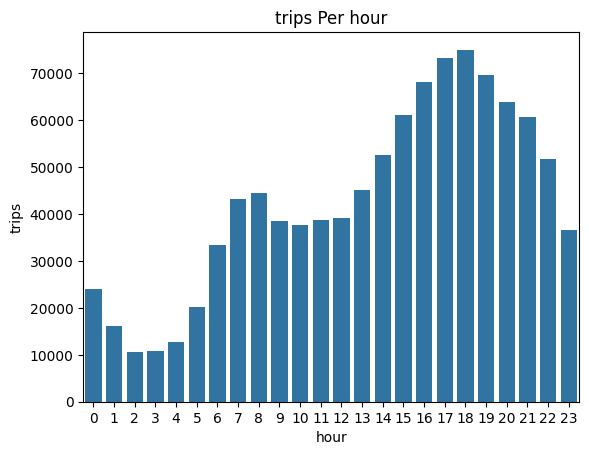

In [69]:
sns.countplot(x='hour', data=df)
plt.title("trips Per hour")
plt.xlabel("hour")
plt.ylabel("trips")
plt.show()

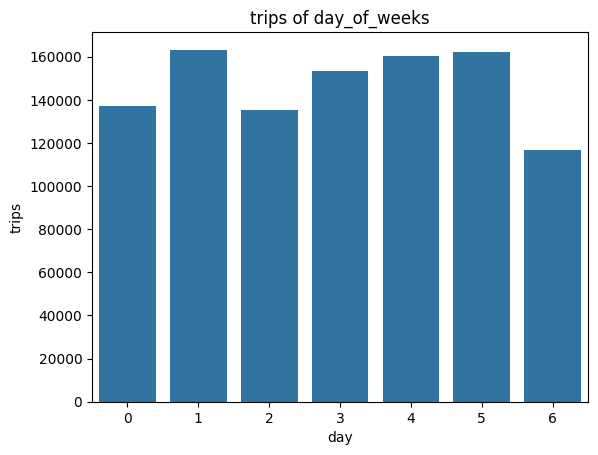

In [12]:
sns.countplot(x='day_of_week', data=df)
plt.title("trips of day_of_weeks")
plt.xlabel("day")
plt.ylabel("trips")
plt.show()

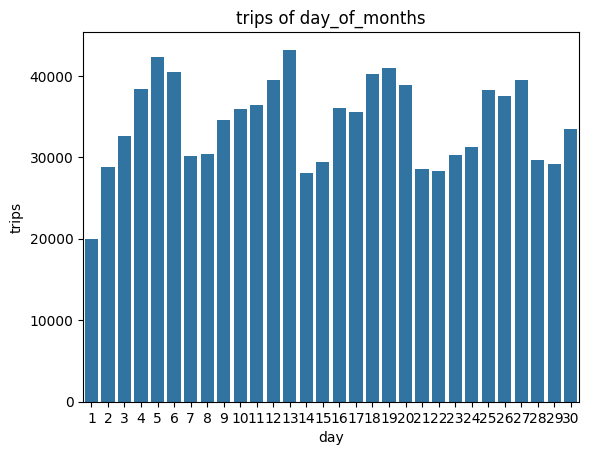

In [13]:
sns.countplot(x='day_of_month', data=df)
plt.title("trips of day_of_months")
plt.xlabel("day")
plt.ylabel("trips")
plt.show()

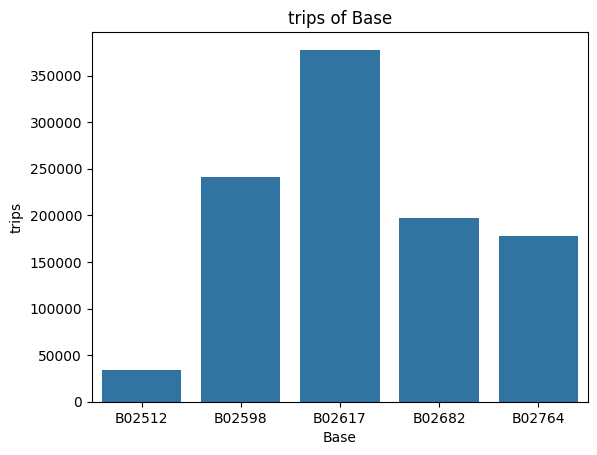

In [14]:
sns.countplot(x='Base',data=df)
plt.title("trips of Base")
plt.xlabel("Base")
plt.ylabel("trips")
plt.show()

In [17]:
df.set_index('Date/Time', inplace=True)
trips_per_hour = df.resample('H').size().reset_index(name='trip_count_per_hour')
trips_per_hour.name = 'Trip Count/hour'
trips_per_day = df.resample('D').size()
trips_per_day.name = 'Trip Count/day'
trips_per_month = df.resample('M').size()
trips_per_month.name = 'Trip Count/month'

In [18]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()
df['Base']= le.fit_transform(df['Base'])

In [78]:

df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_night_hour'] = df['hour'].isin(list(range(0, 6)) + list(range(22, 24))).astype(int)

df_hourly = df.resample('H').agg({
    'Lat': 'mean',
    'Lon': 'mean',
    'Base': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'hour': 'first',
    'day_of_week': 'first',
    'day_of_month': 'first',
    'month': 'first',
    'is_weekend': 'first',
    'is_night_hour': 'first'
}).reset_index()

trip_counts = df.resample('H').size().reset_index(name='trip_count_per_hour')
df_model = pd.merge(df_hourly, trip_counts, on='Date/Time')

df_model['lag_1'] = df_model['trip_count_per_hour'].shift(1)
df_model['rolling_mean_3h'] = df_model['trip_count_per_hour'].rolling(3).mean()
df_model['rolling_std_6h'] = df_model['trip_count_per_hour'].rolling(6).std()
df_model['hour_sin'] = np.sin(2 * np.pi * df_model['hour'] / 24)
df_model['hour_cos'] = np.cos(2 * np.pi * df_model['hour'] / 24)

df_model.dropna(inplace=True)

In [79]:
df_model['lag_2']=df_model['trip_count_per_hour'].shift(2)
df_model['lag_3']=df_model['trip_count_per_hour'].shift(3)
df_model['rolling_mean_6h']=df_model['trip_count_per_hour'].rolling(6).mean()
df_model['rolling_mean_12h']=df_model['trip_count_per_hour'].rolling(12).mean()
df_model.dropna(inplace=True)

X_new = df_model[['lag_1','lag_2','lag_3','rolling_mean_3h','rolling_mean_6h','is_night_hour','rolling_mean_12h','rolling_std_6h','hour_sin','hour_cos']]
y_new = df_model['trip_count_per_hour']
train_size=int(len(X_new)*0.8)
X_train_new,X_test_new=X_new[:train_size],X_new[train_size:]
y_train_new,y_test_new=y_new[:train_size],y_new[train_size:]


In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
rf=RandomForestRegressor()
rf.fit(X_train_new,y_train_new)
pred=rf.predict(X_test_new)

mse=mean_squared_error(y_test_new,pred)
mae=mean_absolute_error(y_test_new,pred)
r2=r2_score(y_test_new,pred)
print("MSE:",mse)
print("MAE:",mae)
print("R2:",r2)

MSE: 7774.557685227275
MAE: 66.59625
R2: 0.9848226195942449


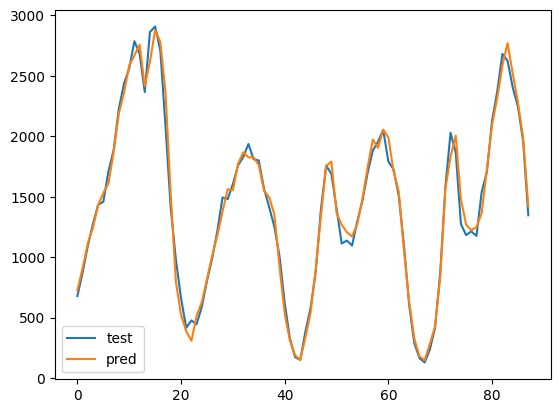

In [57]:
plt.plot(y_test_new.values,label='test')
plt.plot(pred,label='pred')
plt.legend()
plt.show()

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

lr=LinearRegression()

lr.fit(X_train_new,y_train_new)
predlr=lr.predict(X_test_new)

mse=mean_squared_error(y_test_new,pred)
mae=mean_absolute_error(y_test_new,pred)
r2=r2_score(y_test_new,pred)
print("MSE:",ms)
print("MAE:",mae)
print("R2:",r2)

MSE: 7774.557685227275
MAE: 66.59625
R2: 0.9848226195942449


In [62]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

svr=SVR()
svr.fit(X_train_new,y_train_new)
predsvr=svr.predict(X_test_new)

mse=mean_squared_error(y_test_new,pred)
mae=mean_absolute_error(y_test_new,pred)
r2=r2_score(y_test_new,pred)
print("MSE:",mse)
print("MAE:",mae)
print("R2:",r2)

MSE: 7774.557685227275
MAE: 66.59625
R2: 0.9848226195942449


In [63]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

xgb=XGBRegressor()

xgb.fit(X_train_new,y_train_new)
pred_xgb=xgb.predict(X_test_new)

mse=mean_squared_error(y_test_new,pred)
mae=mean_absolute_error(y_test_new,pred)
r2=r2_score(y_test_new,pred)
print("MSE:",mse)
print("MAE:",mae)
print("R2:",r2)

MSE: 7774.557685227275
MAE: 66.59625
R2: 0.9848226195942449


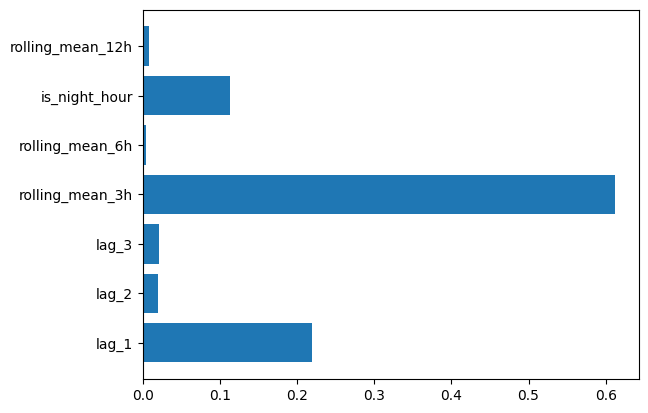

In [64]:
importance=rf.feature_importances_
feature_name=X_new.columns

plt.barh(feature_name,importance)
plt.show()

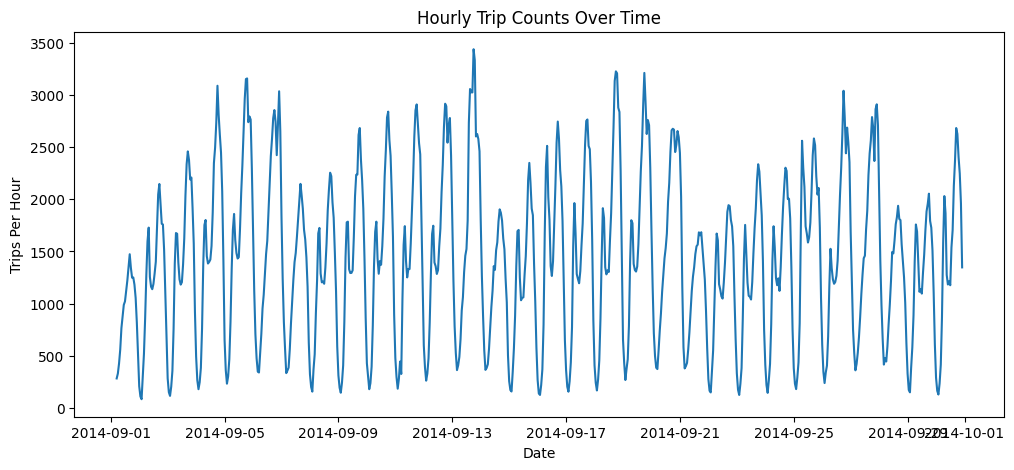

In [32]:
plt.figure(figsize=(12, 5))
plt.plot(df_model['Date/Time'], df_model['trip_count_per_hour'])
plt.xlabel("Date")
plt.ylabel("Trips Per Hour")
plt.title("Hourly Trip Counts Over Time")
plt.show()

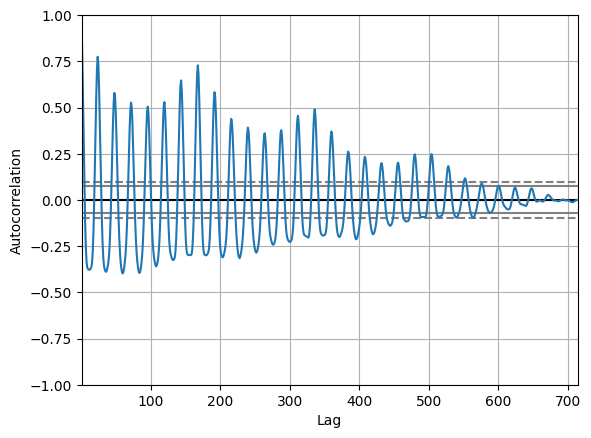

In [33]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df_model['trip_count_per_hour'])
plt.show()

In [34]:
print("RandomForest Params:", rf.get_params())

RandomForest Params: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [80]:
from sklearn.model_selection import RandomizedSearchCV

rf_param_grid= {
    'n_estimators': [100,200,300,500],
    'max_depth' : [5,10,15,20, None],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [1,2,4],
    'max_features' : ['auto','sqrt','log2']
}

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}


rf=RandomForestRegressor(random_state=42)

random_search=RandomizedSearchCV(estimator=rf,param_distributions=rf_param_grid,n_iter=20,
                                 cv=3,verbose=2,random_state=42,n_jobs=-1)

xgb_random = RandomizedSearchCV(XGBRegressor(random_state=42, objective='reg:squarederror'),
                                xgb_param_grid,n_iter=10,cv=3,scoring='r2',verbose=1,random_state=42,
                                n_jobs=-1)
xgb_random.fit(X_train_new, y_train_new)
xgb_best = xgb_random.best_estimator_
xgb_pred = xgb_best.predict(X_test_new)
random_search.fit(X_train_new,y_train_new)
best_model=random_search.best_estimator_
rf_pred=best_model.predict(X_test_new)

mse = mean_squared_error(y_test_new, rf_pred)
mae = mean_absolute_error(y_test_new, rf_pred)
r2 = r2_score(y_test_new, rf_pred)
msexgb = mean_squared_error(y_test_new, xgb_pred)
maexgb = mean_absolute_error(y_test_new, xgb_pred)
r2xgb = r2_score(y_test_new, xgb_pred)
print("Best Parameters:", random_search.best_params_)
print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)

print("Best Parameters fpor xgb:", xgb_random.best_params_)
print("MSE for xgb:", msexgb)
print("MAE for xgb:", maexgb)
print("R2 for xgb:", r2xgb)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
MSE: 11621.48273865248
MAE: 73.81950354609928
R2: 0.9795435972839298
Best Parameters fpor xgb: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
MSE for xgb: 9054.6396484375
MAE for xgb: 70.04219818115234
R2 for xgb: 0.9840618371963501


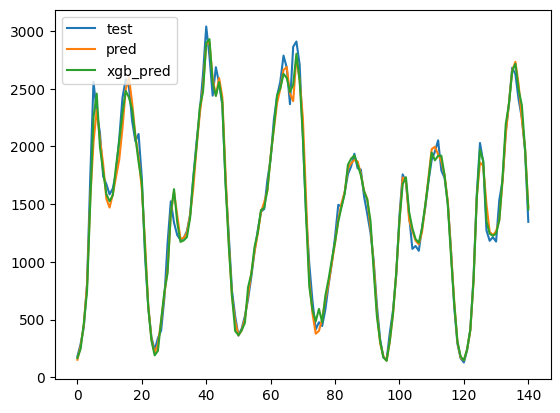

In [81]:
plt.plot(y_test_new.values,label='test')
plt.plot(rf_pred,label='pred')
plt.plot(xgb_pred,label='xgb_pred')
plt.legend()
plt.show()

In [109]:
from sklearn.model_selection import RandomizedSearchCV
import random
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import randint, uniform
gb_params = {
'n_estimators': randint(100, 500),
'learning_rate': uniform(0.01, 0.3),
'max_depth': randint(3, 10),
'min_samples_split': randint(2, 10),
'min_samples_leaf': randint(1, 10),
'subsample': uniform(0.6, 0.4)
}
lgb_params = {
'n_estimators': randint(100, 500),
'learning_rate': uniform(0.01, 0.3),
'max_depth': randint(3, 10),
'num_leaves': randint(20, 100),
'subsample': uniform(0.6, 0.4),
'colsample_bytree': uniform(0.6, 0.4)
}
gb_model = GradientBoostingRegressor()
lgb_model = LGBMRegressor()
gb_search = RandomizedSearchCV(
gb_model, gb_params, n_iter=20, cv=3, scoring='neg_mean_squared_error', verbose=1, random_state=42, n_jobs=-1
)
gb_search.fit(X_train_new, y_train_new)

print("Best GB Parameters:", gb_search.best_params_)
gb_best = gb_search.best_estimator_
lgb_search = RandomizedSearchCV(
lgb_model, lgb_params, n_iter=20, cv=3, scoring='neg_mean_squared_error', verbose=1, random_state=42, n_jobs=-1
)
lgb_search.fit(X_train_new, y_train_new)

print("Best LGB Parameters:", lgb_search.best_params_)
lgb_best = lgb_search.best_estimator_
# Initialize variables to store predictions for each model
gb_preds = []
lgb_preds = []

# Run RandomizedSearchCV for both models
for model_name, model, preds_list in [("Gradient Boosting", gb_best, gb_preds), ("LightGBM", lgb_best, lgb_preds)]:
    preds = model.predict(X_test_new)  # Make predictions
    preds_list.extend(preds)  # Store predictions in the appropriate list

    # Evaluate performance (optional)
    mse = mean_squared_error(y_test_new, preds)
    mae = mean_absolute_error(y_test_new, preds)
    r2 = r2_score(y_test_new, preds)
    print(f"\n{model_name} Results:")
    print(f" MSE: {mse:.2f}")
    print(f" MAE: {mae:.2f}")
    print(f" R² : {r2:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best GB Parameters: {'learning_rate': np.float64(0.0792681476866447), 'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 363, 'subsample': np.float64(0.6137554084460873)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1358
[LightGBM] [Info] Number of data points in the train set: 562, number of used features: 10
[LightGBM] [Info] Start training from score 1441.640569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

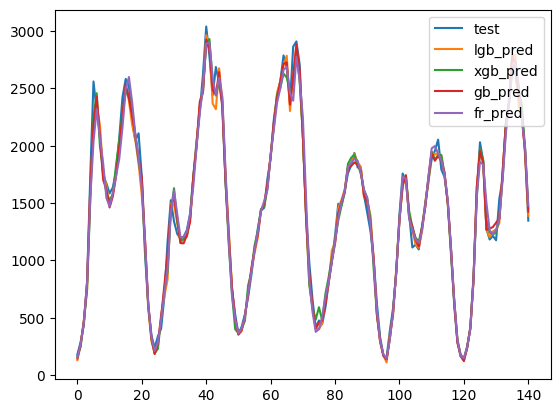

In [113]:
plt.plot(y_test_new.values,label='test')
plt.plot(lgb_preds,label='lgb_pred')
plt.plot(xgb_pred,label='xgb_pred')
plt.plot(gb_preds,label='gb_pred')
plt.plot(rf_pred,label='fr_pred')
plt.legend()
plt.show()

In [114]:
results = [
    {'Model': 'Gradient Boosting', 'MSE': 6431.33, 'MAE': 56.48, 'R²': 0.9887},
    {'Model': 'LightGBM', 'MSE':  8422.78, 'MAE': 63.48, 'R²': 0.9852},
    {'Model': 'Random Forest', 'MSE': 11621.48, 'MAE': 73.81, 'R²': 0.9795},
    {'Model': 'XGBoost', 'MSE': 9054.63, 'MAE': 70.04, 'R²': 0.9840}
]


results_df = pd.DataFrame(results)

results_df


,Model,MSE,MAE,R²
0,Gradient Boosting,6431.33,56.48,0.9887
1,LightGBM,8422.78,63.48,0.9852
2,Random Forest,11621.48,73.81,0.9795
3,XGBoost,9054.63,70.04,0.9840
